<a href="https://colab.research.google.com/github/Hever55/MODELO-VGG19-ADAPTADO/blob/main/MODELO_CNN_PERSONALIZADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle # Import the pickle library




In [2]:
# Montar Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#Estructura del modelo
def build_cnn_model(input_shape=(256, 256, 3), num_classes=10):#BAJAR A LA MITAD
    """
    Construye el modelo CNN.
    """
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model



In [4]:
# Construir el modelo
model = build_cnn_model(input_shape=(256, 256, 3), num_classes=3)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,879,043 (64.39 MB)

 Trainable params: 16,879,043 (64.39 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Rutas de datos
ruta_datos_entrenamiento = '/content/drive/MyDrive/entrenamiento'
ruta_datos_validacion = '/content/drive/MyDrive/validacion'
ruta_datos_prueba = '/content/drive/MyDrive/prueba'


In [6]:
# Tamaño de la imagen y batch size / 128 PRUEBA ----->CAMBIAR TAMBIEN A LA RED. DESPUES SE PEUEBA CON 300 X 300
img_size = (256, 256)
batch_size = 50
# Aumento de datos y preprocesamiento
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
# Cargar datos
train_generator = train_datagen.flow_from_directory(
    ruta_datos_entrenamiento,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    ruta_datos_validacion,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    ruta_datos_prueba,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [7]:
# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [8]:
# Resumen del modelo
model.summary()
# Número de pasos por época
train_steps = train_generator.samples // batch_size
val_steps = val_generator.samples // batch_size
test_steps = test_generator.samples // batch_size
# Early stopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,879,043 (64.39 MB)

 Trainable params: 16,879,043 (64.39 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 684s 14s/step - accuracy: 0.3390 - loss: 2.2442 - val_accuracy: 0.5800 - val_loss: 1.0277 - learning_rate: 0.0010
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 105s 951ms/step - accuracy: 0.5629 - loss: 0.9737 - val_accuracy: 0.7800 - val_loss: 0.6605 - learning_rate: 0.0010
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 961ms/step - accuracy: 0.6672 - loss: 0.7842 - val_accuracy: 0.7600 - val_loss: 0.6312 - learning_rate: 0.0010
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 958ms/step - accuracy: 0.7154 - loss: 0.7011 - val_accuracy: 0.8167 - val_loss: 0.6228 - learning_rate: 0.0010
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 955ms/step - accuracy: 0.7502 - loss: 0.6695 - val_accuracy: 0.7233 - val_loss: 0.6214 - learning_rate: 0.0010
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 971ms/step - accuracy: 0.7408 - loss: 0.6802 - val_accuracy: 0.8133 - val_loss: 0.6106 - learning_rate: 0.0010
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 955ms/step - accuracy: 0.8114 - loss: 0.

In [10]:
# Evaluar el modelo
loss_val, accuracy_val = model.evaluate(val_generator)
print(f"Pérdida de validación: {loss_val:.4f}")
print(f"Precisión de validación: {accuracy_val:.4f}")

loss_test, accuracy_test = model.evaluate(test_generator)
print(f"Pérdida de prueba: {loss_test:.4f}")
print(f"Precisión de prueba: {accuracy_test:.4f}")



6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.8870 - loss: 0.3302
Pérdida de validación: 0.3368
Precisión de validación: 0.8800
6/6 ━━━━━━━━━━━━━━━━━━━━ 68s 12s/step - accuracy: 0.8694 - loss: 0.3743
Pérdida de prueba: 0.3786
Precisión de prueba: 0.8600


In [11]:
# 1. Redefinir el generador de prueba SIN mezclar
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    ruta_datos_prueba,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# 2. Obtener predicciones
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Obtener etiquetas verdaderas
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())



Found 300 images belonging to 3 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step


In [12]:
# 4. Calcular métricas adicionales
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score

kappa = cohen_kappa_score(true_classes, predicted_classes)
mcc = matthews_corrcoef(true_classes, predicted_classes)
balanced_acc = balanced_accuracy_score(true_classes, predicted_classes)

print("\nMétricas adicionales:")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# 5. Curvas ROC y AUC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarizar las etiquetas para multiclase
n_classes = len(class_labels)
y_test_bin = label_binarize(true_classes, classes=np.arange(n_classes))



Métricas adicionales:
Cohen's Kappa: 0.7900
Matthews Correlation Coefficient: 0.7913
Balanced Accuracy: 0.8600


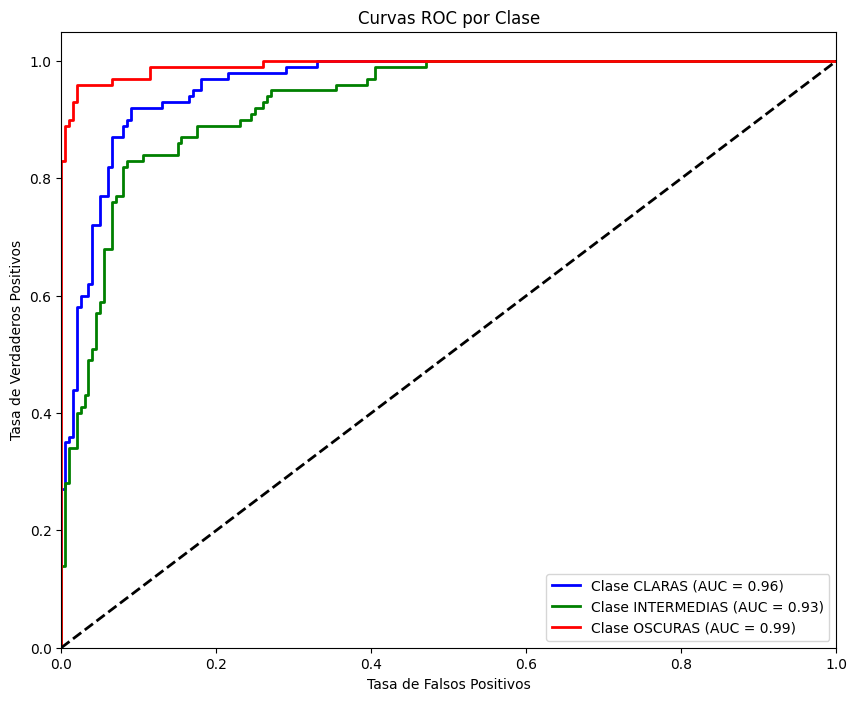


AUC Promedio: 0.9611


In [13]:
# Calcular curvas ROC y áreas para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']  # Ajustar según número de clases

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Clase {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Clase')
plt.legend(loc="lower right")
plt.show()

# AUC Promedio
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nAUC Promedio: {macro_roc_auc:.4f}")


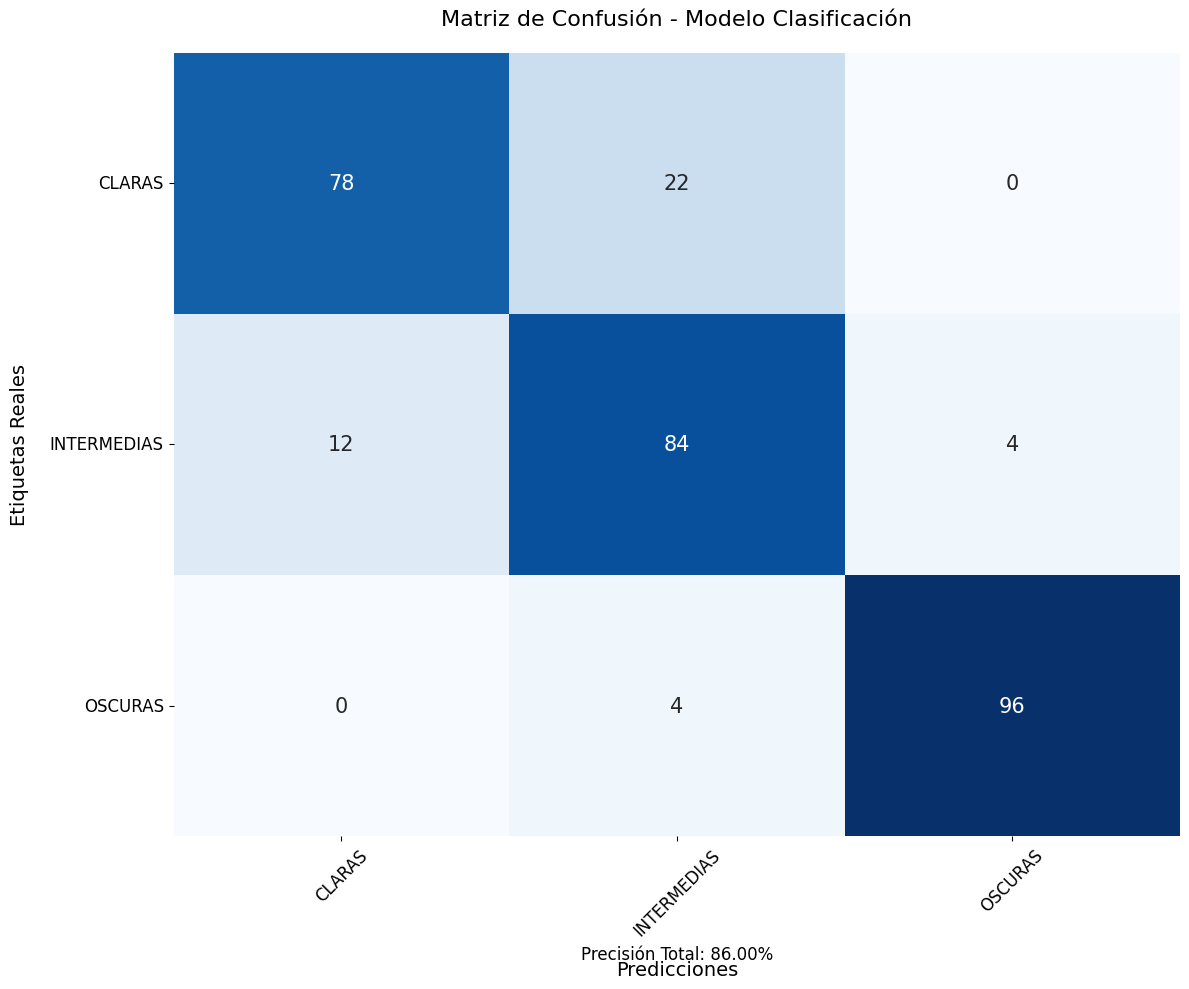


Reporte de Clasificación:
              precision    recall  f1-score   support

      CLARAS       0.87      0.78      0.82       100
 INTERMEDIAS       0.76      0.84      0.80       100
     OSCURAS       0.96      0.96      0.96       100

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



In [14]:
# Calcular matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualización profesional
plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels,
            annot_kws={'size': 15})

plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.xlabel('Predicciones', fontsize=14, labelpad=15)
plt.ylabel('Etiquetas Reales', fontsize=14, labelpad=15)
plt.title('Matriz de Confusión - Modelo Clasificación', fontsize=16, pad=20)

# Añadir precisión total
total_accuracy = np.trace(cm) / np.sum(cm)
plt.text(0.5, -0.15,
         f'Precisión Total: {total_accuracy:.2%}',
         ha='center',
         va='center',
         transform=plt.gca().transAxes,
         fontsize=12)

plt.tight_layout()
plt.show()

#  Métricas adicionales (opcional)
from sklearn.metrics import classification_report
print("\nReporte de Clasificación:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


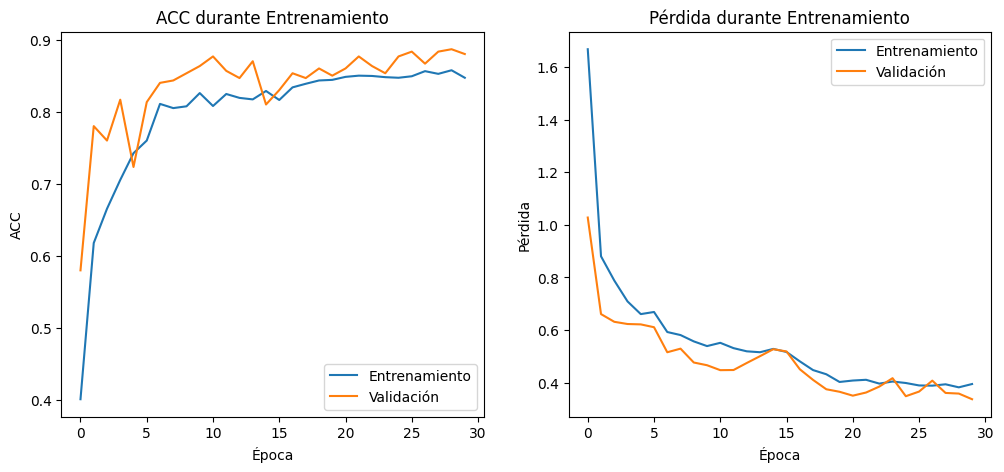

In [15]:
# Gráfico de métricas de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('ACC durante Entrenamiento')
plt.ylabel('ACC')
plt.xlabel('Época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante Entrenamiento')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.show()

In [16]:
# Guardar el modelo usando Pickle
ruta_guardado_pickle = '/content/drive/MyDrive/modelopersonalizado_cnn.pkl'
with open(ruta_guardado_pickle, 'wb') as archivo:
    pickle.dump(model, archivo)

print(f"\nModelo guardado exitosamente en: {ruta_guardado_pickle}")


Modelo guardado exitosamente en: /content/drive/MyDrive/modelopersonalizado_cnn.pkl
